In [1]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import cv2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D # تم دمجها هنا للتسهيل
from keras.utils import to_categorical # تم تصحيح هذا السطر
import pickle
import random
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("✅ تم استيراد المكتبات بنجاح!")

✅ تم استيراد المكتبات بنجاح!


In [3]:
np.random.seed(0)

## Impoting Data

In [4]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 117.80 MiB | 11.60 MiB/s, done.
Updating files: 100% (4/4), done.


In [5]:
with open('german-traffic-signs/train.p','rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
    test_data = pickle.load(f)

In [6]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [7]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [8]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"

## Data Visualisation

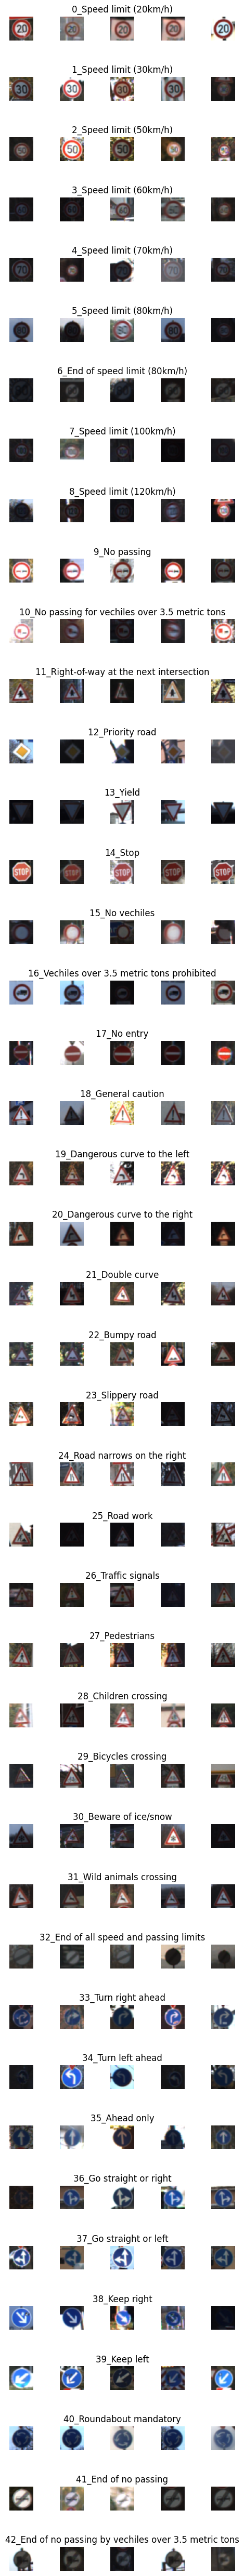

In [9]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5, 50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected)-1)), :, :], cmap = plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "_" + row["SignName"])
            num_of_samples.append(len(x_selected))



[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

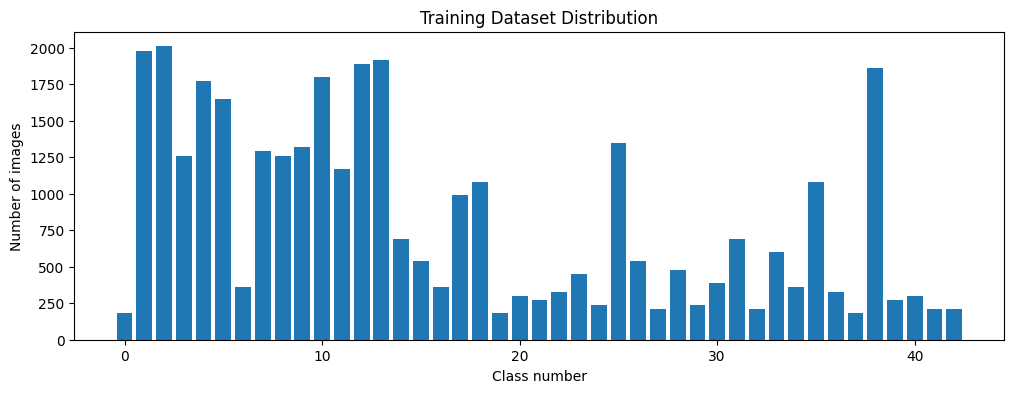

In [10]:
print(num_of_samples)
plt.figure(figsize = (12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Training Dataset Distribution")
plt.xlabel("Class number")
plt.ylabel("Number of images")

## Data Preprocessing

(32, 32, 3)
36


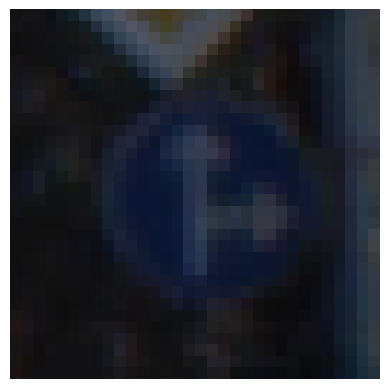

In [11]:
plt.imshow(X_train[1000])
plt.axis('off')
print(X_train[1000].shape)
print(y_train[1000])

In [12]:
def grayscale(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.axis('off')
    return image

(32, 32)


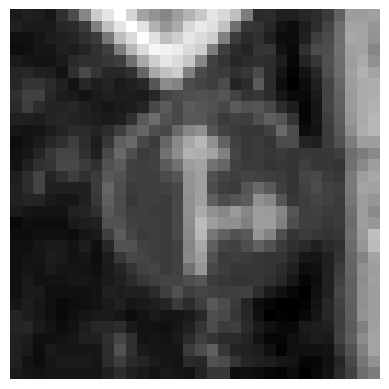

In [13]:
img = grayscale(X_train[1000])
plt.imshow(img, cmap = 'gray')
print(img.shape)

In [14]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

(32, 32)


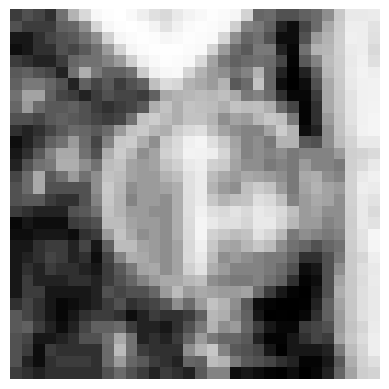

In [15]:
img = equalize(img)
plt.imshow(img, cmap = 'gray')
plt.axis('off')
print(img.shape)

In [16]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

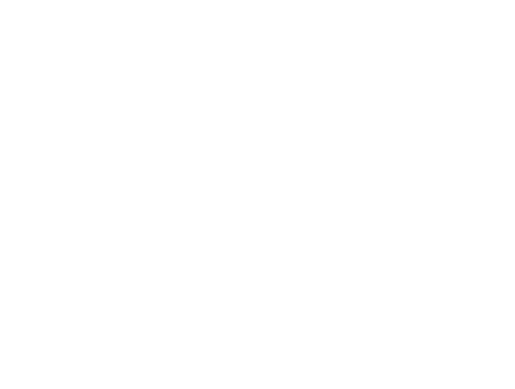

In [17]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

In [18]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1,
                  height_shift_range = 0.1,
                   zoom_range = 0.2,
                  shear_range = 0.1,
                  rotation_range = 10)

datagen.fit(X_train)

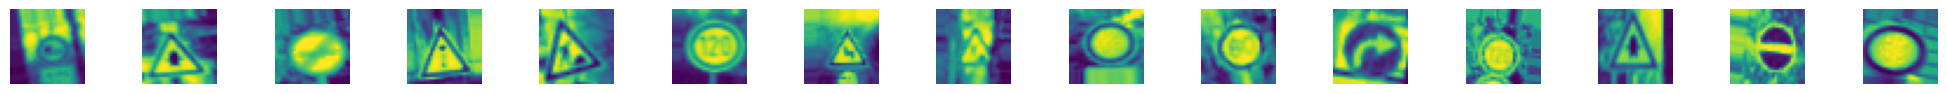

In [20]:
batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [21]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

## Neural Network

In [22]:
from keras.layers import Input

def neural_model():
    model = Sequential()

    # 1. التعديل الأول: استخدام Input object بدلاً من input_shape داخل الطبقة
    model.add(Input(shape=(32, 32, 1)))

    # 2. طبقات الـ Convolution
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))

    # تأكد من أن num_classes معرف لديك بـ 43
    model.add(Dense(num_classes, activation='softmax'))

    # 3. التعديل الثاني الحاسم: تغيير 'lr' إلى 'learning_rate'
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [23]:
model = neural_model()
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None


In [24]:
import numpy as np

# 1. إصلاح أبعاد y_train إذا كانت مشوهة (تحويلها من 3D إلى 1D ثم إلى 2D الصحيح)
if len(y_train.shape) > 2:
    y_train = np.argmax(y_train, axis=1)
if len(y_val.shape) > 2:
    y_val = np.argmax(y_val, axis=1)

# 2. التأكد من التحويل لـ One-Hot Encoding لمرة واحدة فقط (الشكل المطلوب: None, 43)
if len(y_train.shape) == 1 or y_train.shape[1] != 43:
    y_train = to_categorical(y_train, 43)
    y_val = to_categorical(y_val, 43)

# 3. طباعة الأبعاد للتأكد قبل البدء (يجب أن تظهر 43 في خانة واحدة فقط)
print("Corrected y_train shape:", y_train.shape) # يجب أن يطبع (عدد الصور, 43)

# 4. تشغيل التدريب الآن
history = model.fit(datagen.flow(X_train, y_train, batch_size=50),
                    steps_per_epoch=len(X_train) // 50,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    shuffle=True)

Corrected y_train shape: (34799, 43)
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


695/695 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - accuracy: 0.3032 - loss: 2.5449 - val_accuracy: 0.8878 - val_loss: 0.3323
Epoch 2/10
  1/695 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7400 - loss: 0.7030

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


695/695 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - accuracy: 0.7400 - loss: 0.7030 - val_accuracy: 0.9045 - val_loss: 0.3128
Epoch 3/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.8138 - loss: 0.6107 - val_accuracy: 0.9646 - val_loss: 0.1315
Epoch 4/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - accuracy: 0.8800 - loss: 0.3792 - val_accuracy: 0.9728 - val_loss: 0.1109
Epoch 5/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.8971 - loss: 0.3376 - val_accuracy: 0.9717 - val_loss: 0.0906
Epoch 6/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.9600 - loss: 0.1753 - val_accuracy: 0.9717 - val_loss: 0.0945
Epoch 7/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9231 - loss: 0.2431 - val_accuracy: 0.9766 - val_loss: 0.0761
Epoch 8/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step - accuracy: 0.9400 - loss: 0.2137 - val_accuracy: 0.9755 - val_loss: 0.0766
Epoch 9/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.9338 - loss: 0.2115 - val_accurac

In [25]:
# حفظ الموديل بصيغة h5 في درايف
model.save('/content/drive/MyDrive/traffic_sign_model.h5')
print("تم حفظ الموديل بنجاح في Google Drive!")

تم حفظ الموديل بنجاح في Google Drive!


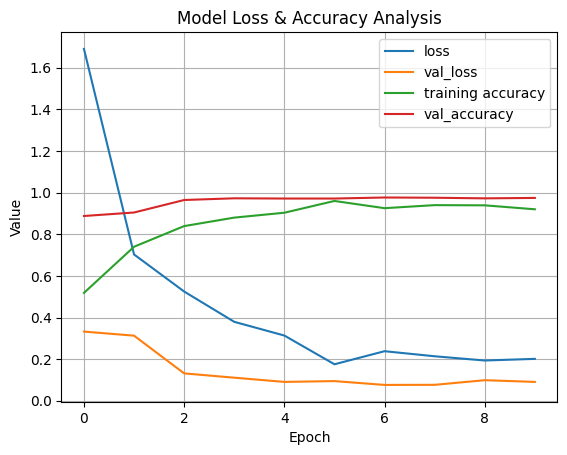

In [26]:
# رسم منحنيات الخسارة والدقة
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy']) # التعديل هنا
plt.plot(history.history['val_accuracy']) # والتعديل هنا

plt.legend(['loss', 'val_loss', 'training accuracy', 'val_accuracy'])
plt.title('Model Loss & Accuracy Analysis')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.grid(True) # إضافة شبكة خلفية لجعل الرسم أوضح للدكتور
plt.show()

In [27]:
score = model.evaluate(X_test, y_test, verbose = 1)
print('Test Score', score[0])
print('Test Accuracy', score[1])

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9478 - loss: 0.1886
Test Score 0.19104456901550293
Test Accuracy 0.9463974833488464


## Testing

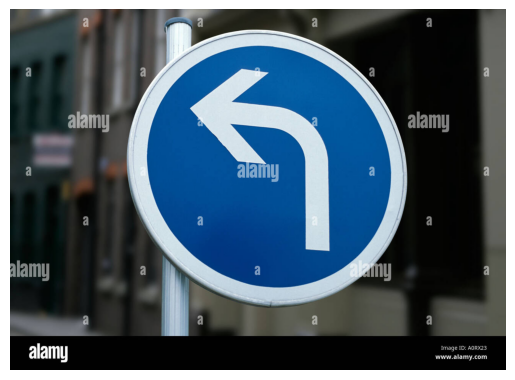

In [28]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
image = Image.open(r.raw)
plt.axis('off')
plt.imshow(image, cmap=plt.get_cmap('gray'))

(32, 32)


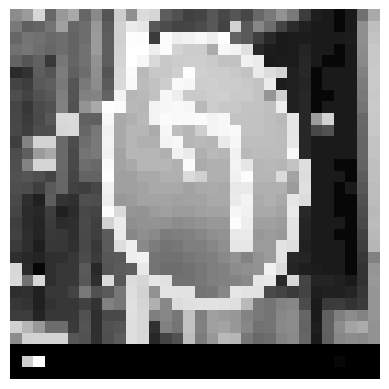

In [29]:
img = np.asarray(image)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)

In [30]:
import numpy as np

# 1. الحصول على احتمالات جميع الفئات
predictions = model.predict(img)

# 2. استخراج رقم الفئة ذات أعلى احتمالية
predicted_class = np.argmax(predictions, axis=-1)

# 3. طباعة النتيجة (تحويلها لنص)
print("predicted sign: " + str(predicted_class[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
predicted sign: 34


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


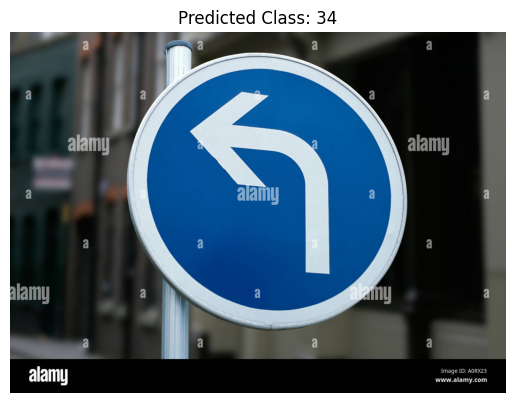

🔍 النتيجة: الموديل يتوقع أن هذه الإشارة هي الفئة رقم: 34


In [31]:
import requests
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. ضع رابط أي صورة إشارة مرور هنا (اخترت لك إشارة تحديد سرعة 30 كم/س)
url = 'https://c8.alamy.com/comp/A0RX23/india-karnataka-bangalore-road-sign-speed-limit-30-kmh-A0RX23.jpg'

try:
    # 2. تحميل الصورة من الإنترنت
    response = requests.get(url, stream=True)
    img = Image.open(response.raw)
    img_array = np.asarray(img)

    # 3. المعالجة (التحويل لرمادي، تسوية التباين، تغيير الحجم)
    img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    img_equalized = cv2.equalizeHist(img_gray)
    img_normalized = img_equalized / 255
    img_resized = cv2.resize(img_normalized, (32, 32))
    img_final = img_resized.reshape(1, 32, 32, 1)

    # 4. التوقع
    predictions = model.predict(img_final)
    pred_class = np.argmax(predictions, axis=-1)[0]

    # 5. العرض
    plt.imshow(img_array)
    plt.title(f"Predicted Class: {pred_class}")
    plt.axis('off')
    plt.show()

    print(f"🔍 النتيجة: الموديل يتوقع أن هذه الإشارة هي الفئة رقم: {pred_class}")

except Exception as e:
    print(f"❌ حدث خطأ أثناء جلب الصورة: {e}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


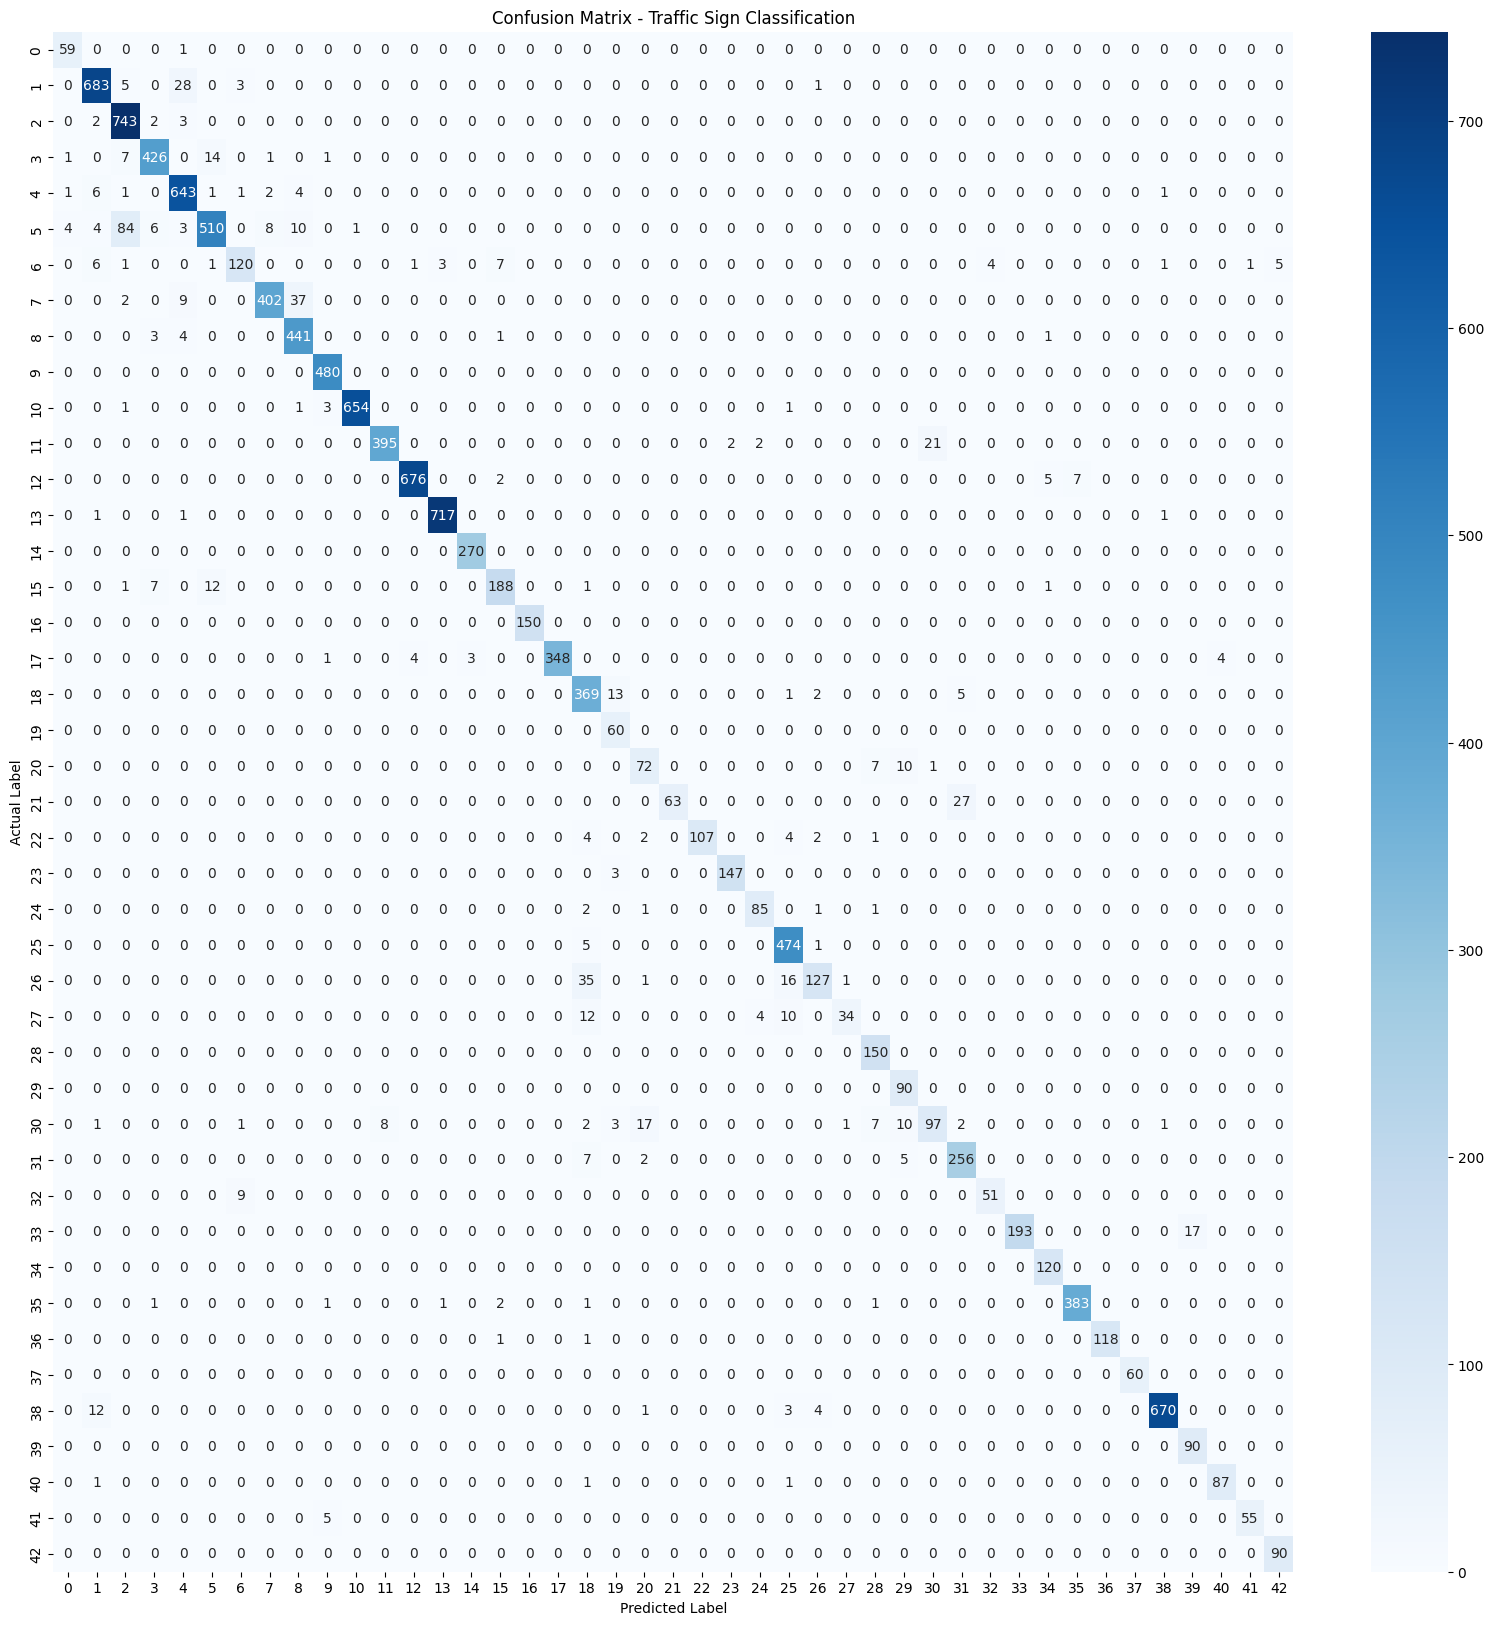


--- Detailed Classification Report ---

              precision    recall  f1-score   support

           0       0.91      0.98      0.94        60
           1       0.95      0.95      0.95       720
           2       0.88      0.99      0.93       750
           3       0.96      0.95      0.95       450
           4       0.93      0.97      0.95       660
           5       0.95      0.81      0.87       630
           6       0.90      0.80      0.85       150
           7       0.97      0.89      0.93       450
           8       0.89      0.98      0.94       450
           9       0.98      1.00      0.99       480
          10       1.00      0.99      0.99       660
          11       0.98      0.94      0.96       420
          12       0.99      0.98      0.99       690
          13       0.99      1.00      1.00       720
          14       0.99      1.00      0.99       270
          15       0.94      0.90      0.91       210
          16       1.00      1.00      1

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. الحصول على التوقعات من النموذج لمجموعة الاختبار
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 2. إنشاء مصفوفة الارتباك
cm = confusion_matrix(y_true, y_pred_classes)

# 3. رسم المصفوفة بشكل احترافي
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Traffic Sign Classification')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. طباعة تقرير الدقة التفصيلي لكل إشارة
print("\n--- Detailed Classification Report ---\n")
print(classification_report(y_true, y_pred_classes))

In [33]:
from keras.models import load_model
import numpy as np
import cv2

# 1. تحميل الموديل من المسار الذي حفظناه فيه في الدرايف
model_path = '/content/drive/MyDrive/traffic_sign_model.h5'
loaded_model = load_model(model_path)

print("✅ تم تحميل الموديل بنجاح! هو الآن جاهز للاختبار.")

✅ تم تحميل الموديل بنجاح! هو الآن جاهز للاختبار.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


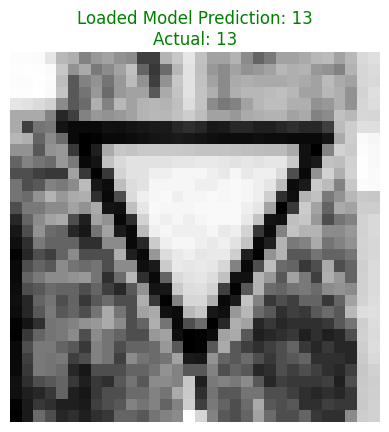

✅ الموديل المحمّل نجح في التعرف على الإشارة (الفئة 13)


In [34]:
import matplotlib.pyplot as plt

# 1. اختيار صورة عشوائية من X_test
random_index = np.random.randint(0, len(X_test))
test_image = X_test[random_index]

# 2. التوقع باستخدام الموديل الذي قمنا بتحميله للتو
# نقوم بعمل reshape للصورة لتناسب مدخلات الموديل (1, 32, 32, 1)
prediction_probs = loaded_model.predict(test_image.reshape(1, 32, 32, 1))
predicted_class = np.argmax(prediction_probs)
actual_class = np.argmax(y_test[random_index])

# 3. عرض النتيجة
plt.imshow(test_image.reshape(32, 32), cmap='gray')
plt.axis('off')
color = "green" if predicted_class == actual_class else "red"
plt.title(f"Loaded Model Prediction: {predicted_class}\nActual: {actual_class}", color=color)
plt.show()

if predicted_class == actual_class:
    print(f"✅ الموديل المحمّل نجح في التعرف على الإشارة (الفئة {predicted_class})")